In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


lr = 0.0001


features = len(X_train.columns)



# Khởi tạo mô hình Sequential
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=(features, 1)))

model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))



# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1639424   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn3_1.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [11]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.3097 - mae: 0.3097 - r2: -1.4902
Epoch 1: val_loss improved from inf to 0.21408, saving model to best_model_cnn3_1.weights.h5
16982/16982 [==============================] - 1160s 65ms/step - loss: 0.3097 - mae: 0.3097 - r2: -1.4902 - val_loss: 0.2141 - val_mae: 0.2141 - val_r2: 0.5676 - lr: 1.0000e-04
Epoch 2/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1710 - mae: 0.1710 - r2: 0.1278
Epoch 2: val_loss improved from 0.21408 to 0.16076, saving model to best_model_cnn3_1.weights.h5
16982/16982 [==============================] - 1076s 63ms/step - loss: 0.1710 - mae: 0.1710 - r2: 0.1278 - val_loss: 0.1608 - val_mae: 0.1608 - val_r2: 0.7531 - lr: 1.0000e-04
Epoch 3/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1646 - mae: 0.1646 - r2: 0.1881
Epoch 3: val_loss improved from 0.16076 to 0.10444, saving model to best_model_cnn3_1.weights.h5
16982/16982 [=============

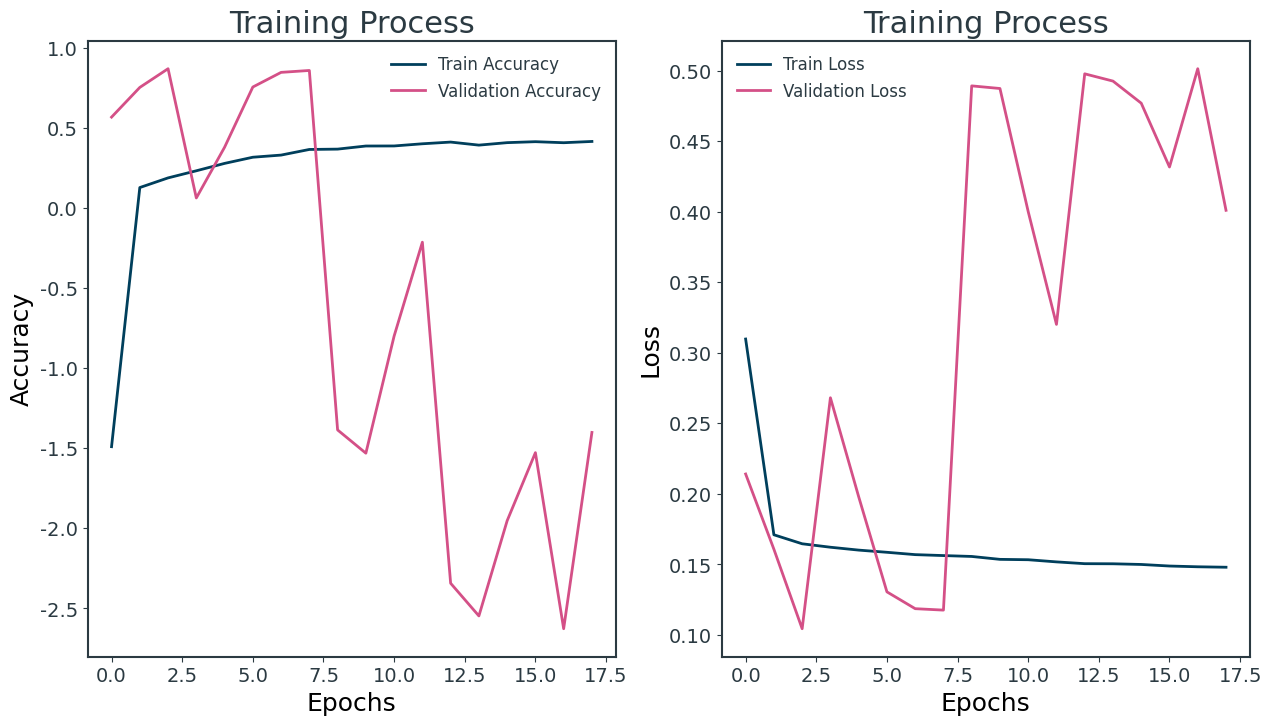

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
model.history.history['r2']

[-1.4902335405349731,
 0.12782999873161316,
 0.1881198137998581,
 0.23251084983348846,
 0.2786577045917511,
 0.3171788156032562,
 0.3305555582046509,
 0.36568984389305115,
 0.36782389879226685,
 0.38719695806503296,
 0.38754773139953613,
 0.4011662006378174,
 0.4117682874202728,
 0.3927537500858307,
 0.4082268178462982,
 0.414236843585968,
 0.4077887535095215,
 0.4156855344772339]

In [14]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.3097171485424042, 0.1710091382265091, 0.16463223099708557, 0.16218450665473938, 0.16014763712882996, 0.15859773755073547, 0.1569390743970871, 0.1562737226486206, 0.155648335814476, 0.15359236299991608, 0.15332527458667755, 0.15179818868637085, 0.15052591264247894, 0.15045364201068878, 0.1499747633934021, 0.1488640308380127, 0.14833003282546997, 0.14800910651683807]
[0.21407614648342133, 0.16076308488845825, 0.10443828999996185, 0.268097847700119, 0.19799265265464783, 0.13055914640426636, 0.11864162236452103, 0.11762559413909912, 0.4891074299812317, 0.48724621534347534, 0.3999921977519989, 0.32009071111679077, 0.497641384601593, 0.49249374866485596, 0.47683361172676086, 0.4316052794456482, 0.5012605786323547, 0.40092822909355164]


In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 [==============================] - 174s 10ms/step
R2 Score: 0.8769942580650033
MAE: 0.10443832560427961
